# Land Use Conflict  

This notebook implements a geographic decision-support model to quantify the land use conflic in Arauca, Casanare and Meta. By performing a comparative spatial analysis between Land Use Cover and Land Use Vocation, the workflow identifies areas where land management is classified into High Conflict, Moderate Conflict, or No Conflict.


### Import libraries

In [1]:
import geopandas as gpd
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import glob

### Load Data

Data obtained from the intersection between **Land Cover** and **Land Use Vocation**

In [2]:
# Folder containing the files
intersection = "./data/lc_voc" 

# List all files in the folder
files = [f for f in os.listdir(intersection)]

gdfs = {}  

# Loop through each file to read it
for file in files:
    path = os.path.join(intersection, file)
    gdf = gpd.read_file(path)
    gdfs[file] = gdf
    

### Conflict classification

In [17]:
# Function to assign a conflict type (High, Moderate, or Non-conflict) depending on the Land Use Cover over a Land Use Vocation type 
def assign_conflict_enviro(row):
    conflict_mapping = {
        "Agricultural": {
            "High": ["11","12","31","51"],
            "Moderate": ["13","32","33","41","14"],
            "No Conflict": ["21","23","24","22"]},

        "Livestock": {
            "High": ["11","12","31","51"],
            "Moderate": ["13","32","33","41","14"],
            "No Conflict": ["21","23","24","22"]},

        "Agroforestry": {
            "High": ["11","12","31","51"],
            "Moderate": ["13","32","33","41","14"],
            "No Conflict": ["21","23","24","22"]},

        "Forestry": {
            "High": ["11","12","13","21","22","23","24","14"],
            "Moderate": ["33"],
            "No Conflict": ["31","32","41","51"]},

        "Conservation": {
            "High": ["11","12","13","21","23","24","22","14"],
            "Moderate": ["33"],
            "No Conflict": ["31","32","41","51"]},

        "Water body": {
            "High": ["11","12","13","21","23","24","22","14"],
            "No Conflict": ["31","32","33","41","51"]},
            
        "Urban areas": {
            "High": ["31","32","33"],
            "Moderate": ["21","22","23","24","41","51"],
            "No Conflict": ["11","12","13","14"]}}

    for level, values in conflict_mapping.get(row["Vocation"], {}).items():
        if row["l2_code"] in values:
            return level

    return "Unknown"


Apply the conflict classification function and save the results for each department

In [18]:
out_dir = "./data/conflict/enviro/nodissolved"
os.makedirs(out_dir, exist_ok=True)

for name, gdf in gdfs.items():
    # Execute the classification logic row-by-row to create the 'conflict' column
    gdf["conflict"] = gdf.apply(assign_conflict_enviro, axis=1)
    # Set up the file paths and layer names for exporting
    out_path = os.path.join(out_dir, name)  
    layer_name = os.path.splitext(name)[0]  
    # Save as GeoPackage (one layer per file)
    gdf.to_file(out_path, driver="GPKG", layer=layer_name)

### Analysis of Land Use Conflict transitions   

This step performs a multi-temporal spatial overlay to identify and quantify changes in land use conflict types over time. By intersecting the conflict maps from different periods (2000, 2010, and 2022), the process isolates specific locations where the conflict status has shifted—such as areas transitioning from "No Conflict" to "High Conflict."

Transition from 2000 to 2010, and 2010 to 2022

In [5]:
def read_conflict_gpkg(dept, year, folder="./data/conflict/enviro/nodissolved"):
    names = [
        f"{dept}_lcvoc_{year}.gpkg",
    ]
    for n in names:
        p = os.path.join(folder, n)
        if os.path.exists(p):
            return gpd.read_file(p)
    raise FileNotFoundError(f"No file found for {dept} {year} in {folder}")

out_dir = "./data/conflict/enviro/conflict_changes"
os.makedirs(out_dir, exist_ok=True)

dept_codes = {"ara":"Arauca", "casa":"Casanare", "meta":"Meta"}
year_pairs = [("2000","2010"), ("2010","2022")]

results_summary = []

for dept in dept_codes:
    for y1, y2 in year_pairs:
        try:
            g1 = read_conflict_gpkg(dept, y1)
            g2 = read_conflict_gpkg(dept, y2)
        except FileNotFoundError as e:
            print(e)
            continue

        # ensure 'conflict' column exists
        if "conflict" not in g1.columns or "conflict" not in g2.columns:
            print(f"Missing 'conflict' column for {dept} {y1} or {y2}")
            continue

        # fix invalid geometries
        for g in (g1, g2):
            try:
                g["geometry"] = g.geometry.buffer(0)
            except Exception:
                pass

        # keep only necessary columns
        g1 = g1[["conflict","geometry"]].copy().rename(columns={"conflict":"conflict_1"})
        g2 = g2[["conflict","geometry"]].copy().rename(columns={"conflict":"conflict_2"})

        # align CRS
        if g1.crs != g2.crs:
            g2 = g2.to_crs(g1.crs)

        # intersection (areas where both layers overlap)
        inter = gpd.overlay(g1, g2, how="intersection")

        if inter.empty:
            print(f"No overlap for {dept} {y1}->{y2}")
            continue

        # keep only features that changed
        changed = inter[inter["conflict_1"] != inter["conflict_2"]].copy()
        if changed.empty:
            print(f"No changes for {dept} {y1}->{y2}")
            continue

        # compute area in m^2 (project to web mercator if geographic)
        try:
            crs = changed.crs
            if crs is None or crs.is_geographic:
                proj = changed.to_crs(epsg=9377)
            else:
                proj = changed.to_crs(crs)  # already projected
        except Exception:
            proj = changed.to_crs(epsg=9377)

        changed["area_m2"] = proj.geometry.area

        # build change type and aggregate
        changed["change"] = changed["conflict_1"].astype(str) + " -> " + changed["conflict_2"].astype(str)
        agg = changed.groupby("change")["area_m2"].sum().reset_index()
        agg["dept"] = dept_codes[dept]
        agg["year_from"] = y1
        agg["year_to"] = y2
        results_summary.append(agg)

        # save polygons of changes
        out_gpkg = os.path.join(out_dir, f"{dept}_{y1}_{y2}_changes.gpkg")
        if os.path.exists(out_gpkg):
            os.remove(out_gpkg)
        changed.to_file(out_gpkg, driver="GPKG", layer=f"{dept}_{y1}_{y2}_changes")
        # save summary csv per pair
        out_csv = os.path.join(out_dir, f"{dept}_{y1}_{y2}_changes_summary.csv")
        agg.to_csv(out_csv, index=False)

        print(f"Saved change polygons: {out_gpkg}  summary: {out_csv}")

# combine summaries into one DataFrame
if results_summary:
    summary_df = pd.concat(results_summary, ignore_index=True)
    # pivot for easier plotting
    pivot = summary_df.pivot_table(index=["dept","year_from","year_to"], columns="change", values="area_m2", fill_value=0).reset_index()
    # also save master summary
    master_csv = os.path.join(out_dir, "all_changes_summary.csv")
    summary_df.to_csv(master_csv, index=False)
    print("Master summary saved:", master_csv)
else:
    pivot = pd.DataFrame()
    print("No changes detected across all departments/pairs.")

# pivot now contains area_m2 per change type per dept/year pair
pivot

c:\Users\VICTUS\anaconda3\envs\osgeo-env-v1\lib\site-packages\ipykernel_launcher.py:49: UserWarning: `keep_geom_type=True` in overlay resulted in 46025 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries


Saved change polygons: ./data/conflict/enviro/conflict_changes\ara_2000_2010_changes.gpkg  summary: ./data/conflict/enviro/conflict_changes\ara_2000_2010_changes_summary.csv


c:\Users\VICTUS\anaconda3\envs\osgeo-env-v1\lib\site-packages\ipykernel_launcher.py:49: UserWarning: `keep_geom_type=True` in overlay resulted in 45419 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries


Saved change polygons: ./data/conflict/enviro/conflict_changes\ara_2010_2022_changes.gpkg  summary: ./data/conflict/enviro/conflict_changes\ara_2010_2022_changes_summary.csv


c:\Users\VICTUS\anaconda3\envs\osgeo-env-v1\lib\site-packages\ipykernel_launcher.py:49: UserWarning: `keep_geom_type=True` in overlay resulted in 224318 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries


Saved change polygons: ./data/conflict/enviro/conflict_changes\casa_2000_2010_changes.gpkg  summary: ./data/conflict/enviro/conflict_changes\casa_2000_2010_changes_summary.csv


c:\Users\VICTUS\anaconda3\envs\osgeo-env-v1\lib\site-packages\ipykernel_launcher.py:49: UserWarning: `keep_geom_type=True` in overlay resulted in 156854 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries


Saved change polygons: ./data/conflict/enviro/conflict_changes\casa_2010_2022_changes.gpkg  summary: ./data/conflict/enviro/conflict_changes\casa_2010_2022_changes_summary.csv


c:\Users\VICTUS\anaconda3\envs\osgeo-env-v1\lib\site-packages\ipykernel_launcher.py:49: UserWarning: `keep_geom_type=True` in overlay resulted in 1032250 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries


Saved change polygons: ./data/conflict/enviro/conflict_changes\meta_2000_2010_changes.gpkg  summary: ./data/conflict/enviro/conflict_changes\meta_2000_2010_changes_summary.csv


c:\Users\VICTUS\anaconda3\envs\osgeo-env-v1\lib\site-packages\ipykernel_launcher.py:49: UserWarning: `keep_geom_type=True` in overlay resulted in 630832 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries


Saved change polygons: ./data/conflict/enviro/conflict_changes\meta_2010_2022_changes.gpkg  summary: ./data/conflict/enviro/conflict_changes\meta_2010_2022_changes_summary.csv
Master summary saved: ./data/conflict/enviro/conflict_changes\all_changes_summary.csv


change,dept,year_from,year_to,High -> Moderate,High -> No Conflict,Moderate -> High,Moderate -> No Conflict,No Conflict -> High,No Conflict -> Moderate,Unknown -> High,Unknown -> Moderate,Unknown -> No Conflict
0,Arauca,2000,2010,9.523245e+08,3.853087e+08,2.062020e+08,7.509057e+08,3.858291e+08,8.386505e+08,0.000000e+00,0.000000e+00,0.000000e+00
1,Arauca,2010,2022,3.834862e+08,7.843790e+08,5.198020e+08,2.353916e+09,7.598990e+08,3.429893e+08,0.000000e+00,0.000000e+00,0.000000e+00
2,Casanare,2000,2010,8.499064e+08,9.984361e+08,2.637327e+08,1.921855e+09,6.330929e+08,1.400855e+09,2.054950e+07,8.978545e+07,2.603720e+07
3,Casanare,2010,2022,5.804314e+08,1.425535e+09,6.932283e+08,5.841173e+09,1.775859e+09,1.139484e+09,0.000000e+00,0.000000e+00,0.000000e+00
4,Meta,2000,2010,8.401019e+08,2.721800e+09,6.082211e+08,2.143703e+09,4.074779e+09,1.640726e+09,6.015743e+07,2.040791e+07,1.025328e+08
5,Meta,2010,2022,7.180039e+08,2.779964e+09,7.056416e+08,3.419550e+09,6.736286e+09,1.164875e+09,0.000000e+00,0.000000e+00,0.000000e+00


Transition from 2000-2022

In [13]:
def read_conflict_gpkg(dept, year, folder="./data/conflict/enviro/nodissolved"):
    names = [
        f"{dept}_lcvoc_{year}.gpkg",
    ]
    for n in names:
        p = os.path.join(folder, n)
        if os.path.exists(p):
            return gpd.read_file(p)
    raise FileNotFoundError(f"No file found for {dept} {year} in {folder}")

out_dir = "./conflict/enviro/conflict_changes"
os.makedirs(out_dir, exist_ok=True)

dept_codes = {"ara":"Arauca", "casa":"Casanare", "meta":"Meta"}
year_pairs = [("2000","2022")]

results_summary = []

for dept in dept_codes:
    for y1, y2 in year_pairs:
        try:
            g1 = read_conflict_gpkg(dept, y1)
            g2 = read_conflict_gpkg(dept, y2)
        except FileNotFoundError as e:
            print(e)
            continue

        # ensure 'conflict' column exists
        if "conflict" not in g1.columns or "conflict" not in g2.columns:
            print(f"Missing 'conflict' column for {dept} {y1} or {y2}")
            continue

        # fix invalid geometries
        for g in (g1, g2):
            try:
                g["geometry"] = g.geometry.buffer(0)
            except Exception:
                pass

        # keep only necessary columns
        g1 = g1[["conflict","geometry"]].copy().rename(columns={"conflict":"conflict_1"})
        g2 = g2[["conflict","geometry"]].copy().rename(columns={"conflict":"conflict_2"})

        # align CRS
        if g1.crs != g2.crs:
            g2 = g2.to_crs(g1.crs)

        # intersection (areas where both layers overlap)
        inter = gpd.overlay(g1, g2, how="intersection")

        if inter.empty:
            print(f"No overlap for {dept} {y1}->{y2}")
            continue

        # keep only features that changed
        changed = inter[inter["conflict_1"] != inter["conflict_2"]].copy()
        if changed.empty:
            print(f"No changes for {dept} {y1}->{y2}")
            continue

        # compute area in m^2 (project to web mercator if geographic)
        try:
            crs = changed.crs
            if crs is None or crs.is_geographic:
                proj = changed.to_crs(epsg=9377)
            else:
                proj = changed.to_crs(crs)  # already projected
        except Exception:
            proj = changed.to_crs(epsg=9377)

        changed["area_m2"] = proj.geometry.area

        # build change type and aggregate
        changed["change"] = changed["conflict_1"].astype(str) + " -> " + changed["conflict_2"].astype(str)
        agg = changed.groupby("change")["area_m2"].sum().reset_index()
        agg["dept"] = dept_codes[dept]
        agg["year_from"] = y1
        agg["year_to"] = y2
        results_summary.append(agg)

        # save polygons of changes
        out_gpkg = os.path.join(out_dir, f"{dept}_{y1}_{y2}_changes.gpkg")
        if os.path.exists(out_gpkg):
            os.remove(out_gpkg)
        changed.to_file(out_gpkg, driver="GPKG", layer=f"{dept}_{y1}_{y2}_changes")
        # save summary csv per pair
        out_csv = os.path.join(out_dir, f"{dept}_{y1}_{y2}_changes_summary.csv")
        agg.to_csv(out_csv, index=False)

        print(f"Saved change polygons: {out_gpkg}  summary: {out_csv}")

# combine summaries into one DataFrame
if results_summary:
    summary_df = pd.concat(results_summary, ignore_index=True)
    # pivot for easier plotting
    pivot = summary_df.pivot_table(index=["dept","year_from","year_to"], columns="change", values="area_m2", fill_value=0).reset_index()
    # also save master summary
    master_csv = os.path.join(out_dir, "all_changes_summary.csv")
    summary_df.to_csv(master_csv, index=False)
    print("Master summary saved:", master_csv)
else:
    pivot = pd.DataFrame()
    print("No changes detected across all departments/pairs.")

# pivot now contains area_m2 per change type per dept/year pair
pivot

c:\Users\VICTUS\anaconda3\envs\osgeo-env-v1\lib\site-packages\ipykernel_launcher.py:49: UserWarning: `keep_geom_type=True` in overlay resulted in 46037 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries


Saved change polygons: ./conflict/enviro/conflict_changes\ara_2000_2022_changes.gpkg  summary: ./conflict/enviro/conflict_changes\ara_2000_2022_changes_summary.csv


c:\Users\VICTUS\anaconda3\envs\osgeo-env-v1\lib\site-packages\ipykernel_launcher.py:49: UserWarning: `keep_geom_type=True` in overlay resulted in 198071 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries


Saved change polygons: ./conflict/enviro/conflict_changes\casa_2000_2022_changes.gpkg  summary: ./conflict/enviro/conflict_changes\casa_2000_2022_changes_summary.csv


c:\Users\VICTUS\anaconda3\envs\osgeo-env-v1\lib\site-packages\ipykernel_launcher.py:49: UserWarning: `keep_geom_type=True` in overlay resulted in 521115 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries


Saved change polygons: ./conflict/enviro/conflict_changes\meta_2000_2022_changes.gpkg  summary: ./conflict/enviro/conflict_changes\meta_2000_2022_changes_summary.csv
Master summary saved: ./conflict/enviro/conflict_changes\all_changes_summary.csv


change,dept,year_from,year_to,High -> Moderate,High -> No Conflict,Moderate -> High,Moderate -> No Conflict,No Conflict -> High,No Conflict -> Moderate,Unknown -> High,Unknown -> Moderate,Unknown -> No Conflict
0,Arauca,2000,2022,7.294309e+08,1.222287e+09,4.402490e+08,2.169137e+09,8.790520e+08,5.673882e+08,0.000000e+00,0.000000e+00,0.000000e+00
1,Casanare,2000,2022,9.261716e+08,2.209904e+09,6.833292e+08,6.353636e+09,1.962877e+09,1.386092e+09,2.213677e+07,6.517472e+07,4.906066e+07
2,Meta,2000,2022,1.083414e+09,3.848872e+09,9.909401e+08,3.878378e+09,8.691651e+09,1.279447e+09,6.313015e+07,1.821010e+07,1.017579e+08


Gain and loss

In [7]:
changes_dir = "./data/conflict/enviro/conflict_changes"
out_dir = changes_dir  # save outputs alongside changes
os.makedirs(out_dir, exist_ok=True)

cats = ["High", "Moderate", "No Conflict"]
master = []

for fname in os.listdir(changes_dir):
    if not fname.endswith("_changes.gpkg"):
        continue
    path = os.path.join(changes_dir, fname)
    base = os.path.splitext(fname)[0]  # e.g. "ara_2000_2010_changes"
    parts = base.split("_")
    # try to extract dept and years (expects pattern dept_y1_y2_changes)
    try:
        dept = parts[0]
        y1 = parts[1]
        y2 = parts[2]
    except Exception:
        dept, y1, y2 = base, "", ""

    g = gpd.read_file(path)
    # ensure geometry valid and metric area
    try:
        g["geometry"] = g.geometry.buffer(0)
    except Exception:
        pass
    try:
        proj = g.to_crs(epsg=9377)
    except Exception:
        proj = g
    proj["area_m2"] = proj.geometry.area
    # use proj for area but keep original crs for outputs (use proj geometries for saving)
    g = proj

    for cat in cats:
        gain_mask = (g["conflict_1"] != cat) & (g["conflict_2"] == cat)
        loss_mask = (g["conflict_1"] == cat) & (g["conflict_2"] != cat)

        gain = g[gain_mask].copy()
        loss = g[loss_mask].copy()

        gain_area = gain["area_m2"].sum() if not gain.empty else 0.0
        loss_area = loss["area_m2"].sum() if not loss.empty else 0.0

        # save layers if non-empty (dissolved or individual as needed)
        if not gain.empty:
            out_gpkg = os.path.join(out_dir, f"{dept}_{y1}_{y2}_{cat.replace(' ','').lower()}_gain.gpkg")
            if os.path.exists(out_gpkg):
                os.remove(out_gpkg)
            gain.to_file(out_gpkg, driver="GPKG", layer=os.path.splitext(os.path.basename(out_gpkg))[0])
        if not loss.empty:
            out_gpkg = os.path.join(out_dir, f"{dept}_{y1}_{y2}_{cat.replace(' ','').lower()}_loss.gpkg")
            if os.path.exists(out_gpkg):
                os.remove(out_gpkg)
            loss.to_file(out_gpkg, driver="GPKG", layer=os.path.splitext(os.path.basename(out_gpkg))[0])

        # append to master summary
        master.append({
            "dept": dept,
            "year_from": y1,
            "year_to": y2,
            "category": cat,
            "gain_area_m2": gain_area,
            "loss_area_m2": loss_area
        })

# master summary CSV
master_df = pd.DataFrame(master)
master_csv = os.path.join(out_dir, "changes_gain_loss_by_category.csv")
master_df.to_csv(master_csv, index=False)

print("Saved gain/loss layers and master summary:", master_csv)

Saved gain/loss layers and master summary: ./data/conflict/enviro/conflict_changes\changes_gain_loss_by_category.csv


### Visualization

Dissolve by conflict

In [ ]:
# Output folder
out_dir = "./data/conflict/enviro/dissolved"

# New dictionary to store dissolved GeoDataFrames
conflict = {}

for name, gdf in gdfs.items():
    # Dissolve by conflict column
    dissolved = gdf.dissolve(by="conflict")

    # Reset index so "conflict" becomes a regular column again
    dissolved = dissolved.reset_index()
    
    # Keep only conflict + geometry columns
    dissolved = dissolved[["conflict", "geometry"]]
    
    # Store in dictionary
    conflict[name] = dissolved
    
    # Build output path (same base name, gpkg format)
    base_name = os.path.splitext(name)[0]   # remove .gpkg extension
    output_path = os.path.join(out_dir, f"{base_name}_conflict.gpkg")
    
    # Save to GeoPackage
    dissolved.to_file(output_path, driver="GPKG", layer=base_name+"_conflict")
    
    print(f"Saved: {output_path}")

Plot

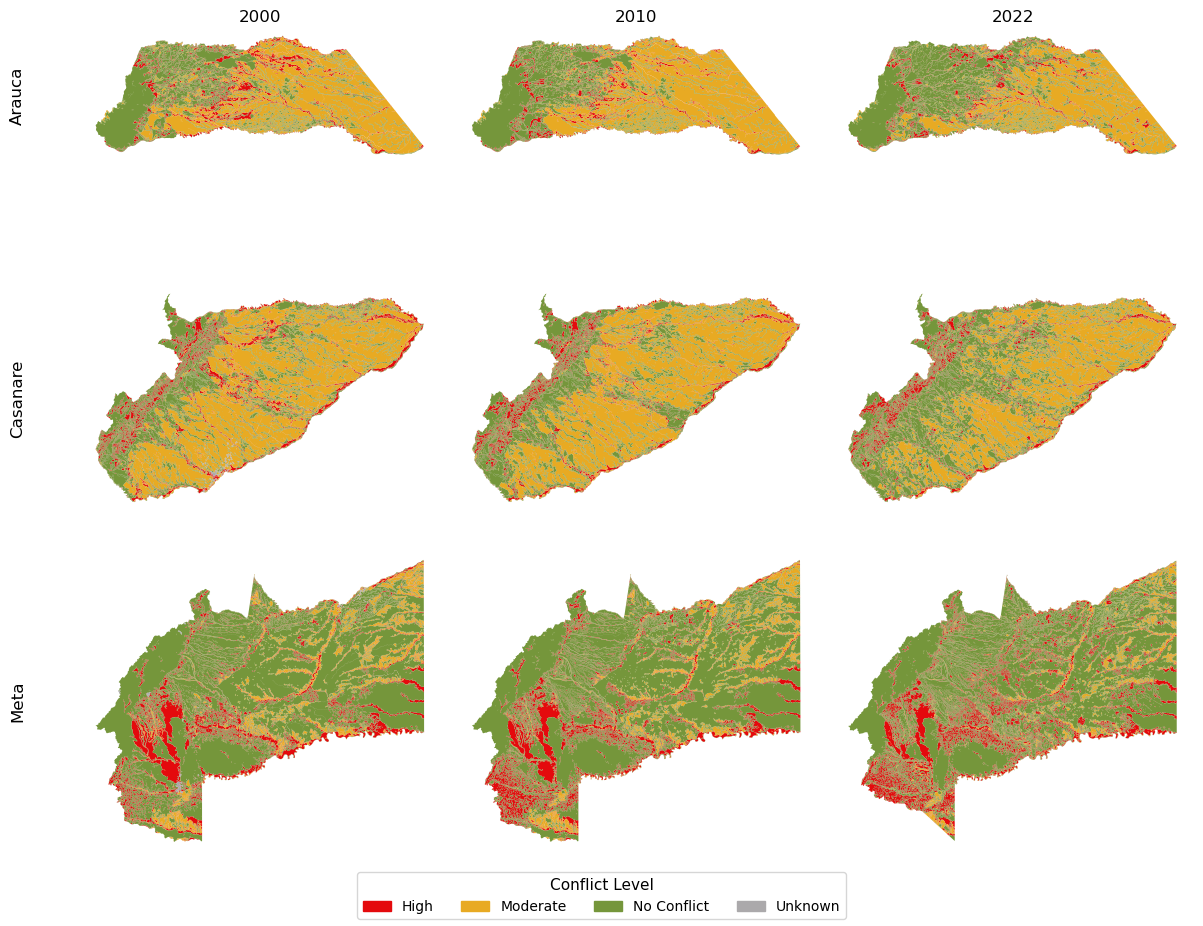

Figure saved as: ./data/conflict/conflict_enviro.pdf


In [9]:
# Define departments and years
departments = ["ara", "casa", "meta"]
department_labels = {
    "ara": "Arauca",
    "casa": "Casanare",
    "meta": "Meta"
}
years = ["2000", "2010", "2022"]

# Custom color mapping for conflict categories
conflict_colors = {
    "High": "#e40a0d",        # red
    "Moderate": "#e8aa23",    # orange
    "No Conflict": "#75963b", # green
    "Unknown": "#aba9ab"      # gray
}

# Create 3x3 subplot grid
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 10))

# Loop through rows (departments) and columns (years)
for i, dept in enumerate(departments):
    for j, year in enumerate(years):
        ax = axes[i, j]
        key = f"{dept}_lcvoc_{year}.gpkg"

        # Skip if missing
        if key not in conflict:
            ax.set_visible(False)
            continue

        gdf = conflict[key]
        gdf["color"] = gdf["conflict"].map(conflict_colors)

        # Plot polygons (no borders)
        gdf.plot(color=gdf["color"], ax=ax)

        # Add year label on top
        if i == 0:
            ax.set_title(year, fontsize=12)

        # Add department label on the left
        if j == 0:
            ax.text(
                -0.15, 0.5, department_labels[dept],
                fontsize=12,
                va="center", ha="right", rotation=90,
                transform=ax.transAxes
            )

        ax.set_axis_off()

# Create a legend
legend_patches = [
    mpatches.Patch(color=color, label=label.title())
    for label, color in conflict_colors.items()
]

fig.legend(
    handles=legend_patches,
    loc="lower center",
    ncol=4,
    title="Conflict Level",
    fontsize=10,
    title_fontsize=11
)

plt.tight_layout(rect=[0, 0.05, 1, 1])  # Make space for the legend

# Save figure as pdf
output_path = "./data/conflict/conflict_enviro.pdf"
plt.savefig(output_path, format="pdf", bbox_inches="tight", dpi=300)

plt.show()
print(f"Figure saved as: {output_path}")


### Conflict area in percentages

In [10]:
# Folder containing the GeoPackage files
conflict_path = "./data/conflict/enviro/dissolved"

# Dictionary to store the GeoDataFrames
conflict = {}

# Loop through all files in the folder
for file in os.listdir(conflict_path):
    if file.endswith(".gpkg"):
        # Remove the file extension to use as key
        key = os.path.splitext(file)[0]
        # Read the GeoPackage file
        gdf = gpd.read_file(os.path.join(conflict_path, file))
        # Store it in the dictionary
        conflict[key] = gdf

# Check the keys to confirm
print(conflict.keys())

dict_keys(['ara_lcvoc_2000_conflict', 'ara_lcvoc_2010_conflict', 'ara_lcvoc_2020_conflict', 'ara_lcvoc_2022_conflict', 'casa_lcvoc_2000_conflict', 'casa_lcvoc_2010_conflict', 'casa_lcvoc_2020_conflict', 'casa_lcvoc_2022_conflict', 'meta_lcvoc_2000_conflict', 'meta_lcvoc_2010_conflict', 'meta_lcvoc_2020_conflict', 'meta_lcvoc_2022_conflict'])


Calculate area

In [11]:
conflict["ara_lcvoc_2000_conflict"]["area"] = conflict["ara_lcvoc_2000_conflict"].geometry.area
conflict["ara_lcvoc_2010_conflict"]["area"] = conflict["ara_lcvoc_2010_conflict"].geometry.area
conflict["ara_lcvoc_2022_conflict"]["area"] = conflict["ara_lcvoc_2022_conflict"].geometry.area

conflict["casa_lcvoc_2000_conflict"]["area"] = conflict["casa_lcvoc_2000_conflict"].geometry.area
conflict["casa_lcvoc_2010_conflict"]["area"] = conflict["casa_lcvoc_2010_conflict"].geometry.area
conflict["casa_lcvoc_2022_conflict"]["area"] = conflict["casa_lcvoc_2022_conflict"].geometry.area

conflict["meta_lcvoc_2000_conflict"]["area"] = conflict["meta_lcvoc_2000_conflict"].geometry.area
conflict["meta_lcvoc_2010_conflict"]["area"] = conflict["meta_lcvoc_2010_conflict"].geometry.area
conflict["meta_lcvoc_2022_conflict"]["area"] = conflict["meta_lcvoc_2022_conflict"].geometry.area

In [14]:
# Calculate total areas for each department/year combination
def calculate_percentages(dept, year):
    key = f"{dept}_lcvoc_{year}_conflict"
    gdf = conflict[key]
    total_area = gdf['area'].sum()
    
    percentages = {}
    for cat in ['High', 'Moderate', 'No Conflict']:
        area = gdf.loc[gdf['conflict'] == cat, 'area'].sum()
        percentages[cat] = (area / total_area) * 100
    
    return percentages

# Create DataFrame for percentages
percentage_summary = pd.DataFrame()
percentage_summary["Department"] = ["Arauca", "Casanare", "Meta"]

# Calculate percentages for each year
for year in ["2000", "2010", "2022"]:
    for category in ["High", "Moderate", "No Conflict"]:
        col_name = f"{year}_{category}_%"
        percentage_summary[col_name] = [
            calculate_percentages("ara", year)[category],
            calculate_percentages("casa", year)[category],
            calculate_percentages("meta", year)[category]
        ]

# Round percentages to 2 decimal places
percentage_summary = percentage_summary.round(2)

# Display the results
print("Percentage of area by conflict category:")
print(percentage_summary.to_string())

output_path = "./data/conflict/enviro/conflict_percentages.csv"
percentage_summary.to_csv(output_path, index=False)

Percentage of area by conflict category:
  Department  2000_High_%  2000_Moderate_%  2000_No Conflict_%  2010_High_%  2010_Moderate_%  2010_No Conflict_%  2022_High_%  2022_Moderate_%  2022_No Conflict_%
0     Arauca        14.86            48.28               36.86        11.72            51.79               36.49        12.17            42.85               44.98
1   Casanare        14.85            54.34               30.50        12.75            54.69               32.56        13.80            43.81               42.39
2       Meta        19.50            11.42               68.87        20.88            11.13               67.99        25.11             8.14               66.75
